# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.

1. Accuracy can be used to check if your model works well when doing classification. For example, when we have multiple groups of people, and we must let the computer make a prediction who is in which group. The model can then try to guess which person belongs to what group. An assumption for this model to work could be that every group is equally important to forecast (in)correctly. If we want a certain group to be better forecasted than the others (such that misidentifying a person belong to a group is worse in scenario A than B), we could use the precision measure. This measure looks at how many of the persons predicted to be in a certain group, were correct. for example, predicting whether a passenger on an airplane is a terrorist must be done with precision, it is unacceptable to name a tourist a terrorist if he is not. We could also use the recall rate in this example, namely not spotting a terrorist while there is one is also unacceptable. Therefore, we should also have a high recall rate because otherwise we would not classify all terrorists as terrorists.
2. accuracy could fail when a model needs to determine which person is in what group. It fails if the sizes of the group differ significantly. In this scenario, to get a high accuracy, the model could predict every person to be in group A, since for example most people were from A. If you would like to minimise false negatives, then you should not use precision. Therefore, for example if you are a doctor, you should mostly look at spotting all ill clients and take the risk to further examine a person while he in fact is healthy. Recall fails when using recommendation systems. It is far worse to not send an advertisement to an interested customer than to send one to a non interested customer. Thus, with the recall rate, we neglect the false positives. All performance measures fail if the group sizes are low. The performance measures then fail to deliver reliable results.
3. The F1-score could be helpful when determining which passenger on a plane is a terrorist. This is because we do not want to identify normal passengers as terrorists but also don't want to miss any terrorists.


## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

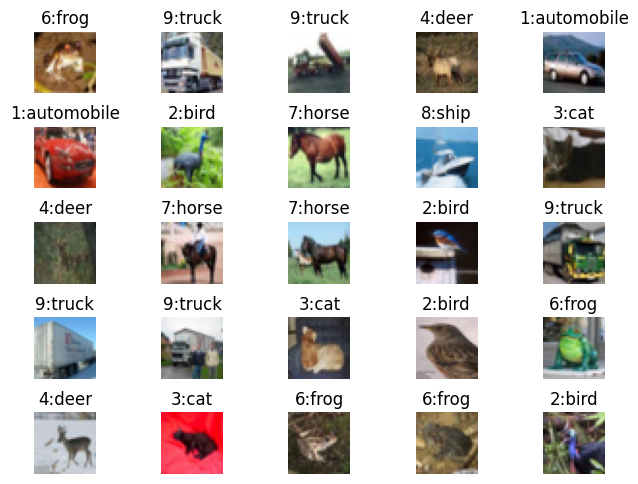

In [17]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

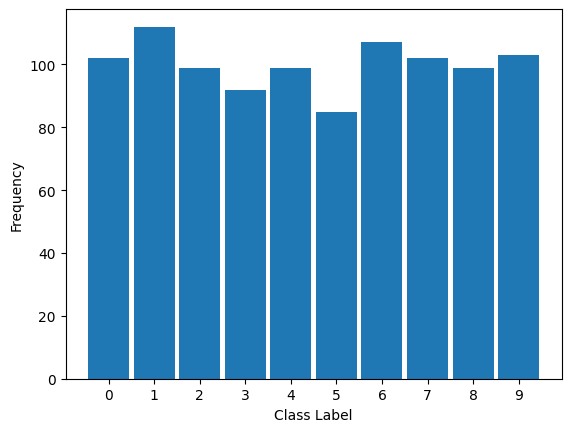

In [18]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [19]:
# Your answer here
print(train_X[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


**Q 2.1.1** What does each value in the tuple that was printed out mean?

Every tuple has 32 rows with each row having 32 smaller lists. each list represents the 3 base colours to identify the final colour that is attached to that specific pixel in the picture

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [20]:
# the length of this vector is 32*32*3 since there are 32*32 pixels and every pixel has 3 'base'-colours attached to them.
# we should make then all in 1 giant list?
def flatten_cifar10(samples):
    return samples.reshape(samples.shape[0], -1)

train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X)
# to test first value
print(train_X[0])

[ 59  62  63 ... 123  92  72]


## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [21]:
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression() # create the logistic regression object
modelLR = modelLR.fit(train_X, train_y) # fit on training data
print("Training score:", modelLR.score(train_X, train_y))
print("Testing score: ", modelLR.score(test_X, test_y))

Training score: 0.948
Testing score:  0.257


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

No the model does not work wel, it has a high training score and a low testing score which leads us to believe that overfitting is present in our dataset

### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [ ]:
from sklearn import tree

train_acc_mean, train_acc_std = [], [] # to store the training accuracies
test_acc_mean, test_acc_std = [], []   # to store the testing accuracies

for d in tqdm(range(15)):
    d = d + 1 # loop over tree depths
    train_perfs = [] # store interem train scores
    test_perfs = []  # store interem test scores
    for n in range(10):   # loop over random initializations
        # init new model
        modelDT = tree.DecisionTreeClassifier(max_depth=d)
        modelDT = modelDT.fit(train_X, train_y)
        # train model
        # store interem values
        train_perfs.append(modelDT.score(train_X, train_y))
        test_perfs.append(modelDT.score(test_X, test_y))
    # append mean and std scores to appropriate lists
    train_acc_mean.append(np.average(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.average(test_perfs))
    test_acc_std.append(np.std(test_perfs))


100%|██████████| 15/15 [04:50<00:00, 19.36s/it]


**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

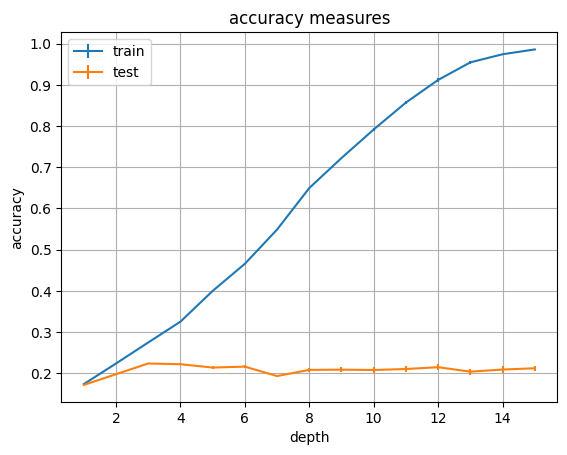

In [ ]:
plt.errorbar(x=np.array(range(15))+1, y=train_acc_mean, yerr=train_acc_std, label = 'train')
plt.errorbar(x=np.array(range(15))+1, y=test_acc_mean, yerr=test_acc_std, label = 'test')
plt.title("accuracy measures")
plt.ylabel("accuracy")
plt.xlabel("depth")
plt.grid()
plt.legend()
plt.show()

**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?
2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?
3. At what depth do models start to overfit the training data?

1. no probably not, although the train_accuracy performance increases significantly if we increase the depth, all decision trees regardless of depth tend to perform the same. All trees have an accuracy of roughly 22% which is very bad.
2. the model with depth = 15 performed best on the training_set while all models performed roughly the same on the test_data. The model with depth = 3 was however marginally better than the other models
3. It is difficult to say here because all models perform bad, but since the model with depth = 3 has the highest accuracy, I would say that from depth = 4 onwards, the model starts overfitting  

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8)) # storing it in an np array instead of a list makes it easier
test_acc_mean, test_acc_std = np.zeros((10, 8)), np.zeros((10, 8))

#n_trees gets overwritten later in this chunk of code
n_trees = (np.array(range(10))+1)*10
depths = (np.array(range(8)))*2+1

for tree_idx, n_trees in tqdm(enumerate(n_trees), total=len(n_trees)):
    for d_idx, d in enumerate(depths):
        train_perfs = []
        test_perfs = []
        for n in range(5):
            # init new model
            # train model
            modelRFC = RFC(n_trees, max_depth=d)
            modelRFC = modelRFC.fit(train_X, train_y)
            # store interem values
            train_perfs.append(modelRFC.score(train_X, train_y))
            test_perfs.append(modelRFC.score(test_X, test_y))
        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)

100%|██████████| 10/10 [09:57<00:00, 59.78s/it]


Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

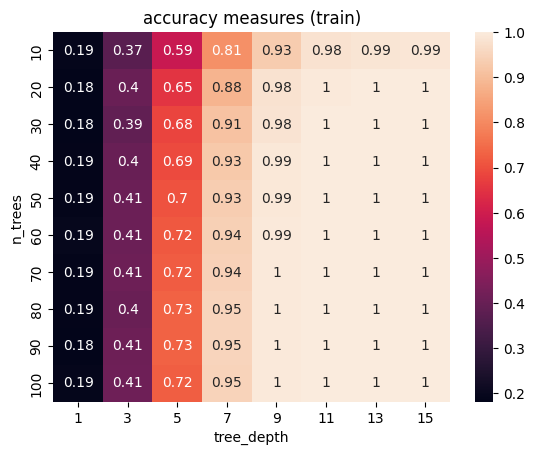

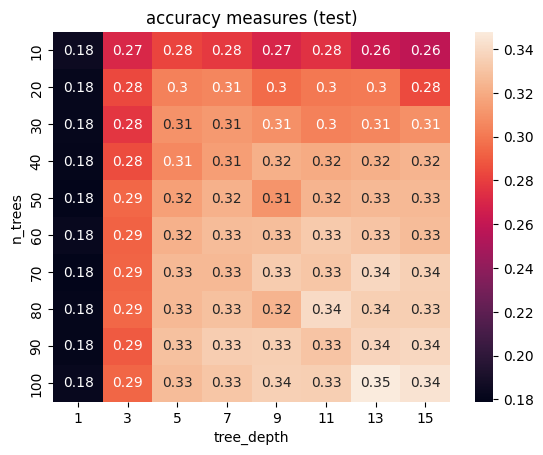

In [ ]:
import seaborn as sns
# Figure 1
plt.figure()
sns.heatmap(train_acc_mean, xticklabels=depths, yticklabels=(np.array(range(10))+1)*10, annot=True) # create seaborn heatmap with annotations
# add proper xticklabels and yticklabels
# add a title
plt.title("accuracy measures (train)")
plt.xlabel("tree_depth")
plt.ylabel("n_trees")
plt.show()

# Figure 2
plt.figure()
sns.heatmap(test_acc_mean, xticklabels=depths, yticklabels=(np.array(range(10))+1)*10, annot=True)
# create seaborn heatmap with annotations
# add proper xticklabels and yticklabels
# add a title
plt.title("accuracy measures (test)")
plt.xlabel("tree_depth")
plt.ylabel("n_trees")
plt.show()

**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?
2. What model performs best on the train set? What model performs best on the test set?
3. What model would you choose to deploy and why?

1. If we increase the number of trees and the tree_depth (either seperately or together), our model performs better.
2. There are multiple models that achieve the highest possible accuracy on our train set like the model with depth equals 15 and n_trees equals 100. On the test set, the model with depth equals 13 and n_trees equals 100 performs best.
3. I would choose the model that performs best on the test set. This is because this models reacts best on new data and not on the data on which is has been trained. I would thus choose the model with tree depth equals 13 and n_trees equals 100.

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_svm = [
    {'kernel': ['linear'],
     'C': [0.1,1,100],
     'degree': [2,3],
     'gamma': [0.01,1,100]}
]

# create the cross-validation object
optimal_params_svm = GridSearchCV(
    estimator = SVC(),             # support vector classifier instance
    param_grid = param_grid_svm,              # grid search params
    cv = 5,                      # k=5 CV
    scoring='accuracy',            # use accuracy measure for best hyperparameters
)

optimal_params_svm.fit(train_X, train_y)
print("since I still had not recieved output after a full 3 hours of running, I decided to give my svm model less parameters, this of course does hurt its performance")
print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)

The best parameters are {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'linear'} with a score of 0.31


**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

1. 3 * 4 * 3 * 5 = 180; this is because every combination is possible.
2. 5 * 180 = 900; since for every combination of parameters you train 5 models, we get 300 trained models in total

**Q 3.4.3**
Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [14]:
param_grid_svm = [
    {'kernel': ['linear'],
     'C': [0.1],
     'degree': [2],
     'gamma': [0.01]}
]

modelSVC = SVC(kernel="linear", C = 0.1, degree = 2, gamma = 0.01) # create model
modelSVC = modelSVC.fit(train_X, train_y)      # train model
print("Training score:", modelSVC.score(train_X, train_y))
print("Testing score: ", modelSVC.score(test_X, test_y))

Training score: 1.0
Testing score:  0.294


## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*

In [22]:
from time import perf_counter # used to compute intervals
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

n_train, n_test = 5000, 5000
train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test) # get data
train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X) # flatten images

# set up lists to store scores and times
train_scores = []
test_scores = []
fit_times = []
inf_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """ Trains, times and evaluates a given instantiated model on data """

    start = perf_counter()               # check current (start) time
    model = model.fit(train_X, train_y)               # perform some code that you want to time
    end = perf_counter()                 # check current (end) time
    fit_time = end-start                 # compute interval

    # time inference over train score
    start = perf_counter()
    train_score = model.score(train_X, train_y)
    end = perf_counter()
    train_score_time = end-start

    # time inference over test score
    start = perf_counter()
    test_score = model.score(test_X, test_y)
    end = perf_counter()
    test_score_time = end-start

    return train_score, test_score, fit_time, train_score_time, test_score_time

# create models
modelLR = LogisticRegression()
modelDT = tree.DecisionTreeClassifier(max_depth=3)
modelRFC = RFC(100, max_depth=13)
modelSVC = SVC(kernel="linear", C = 0.1, degree = 2, gamma = 0.01)

for model in tqdm([modelLR, modelDT, modelRFC, modelSVC]):
    train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(model, train_X, train_y, test_X, test_y)
    # add these values to the list set up above
    # don't forget that the training and inference times should be stored per image and not for the whole run
    train_scores.append(train_score)
    test_scores.append(test_score)
    fit_times.append(fit_time/n_train)
    inf_times.append(train_score_time/n_train)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [05:03<00:00, 75.96s/it] 


Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

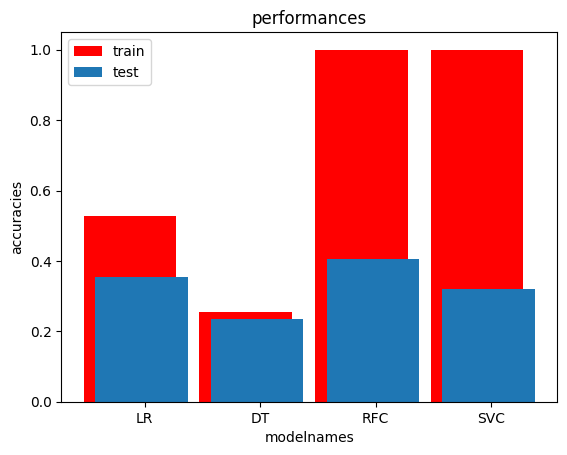

In [35]:
model_names = ["LR","DT","RFC","SVC"]
bar_width = 0.25

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(x, train_scores, color ='r', label ='train') # training accuracy: don't forget to add labels
bar2 = ax.bar(x+0.1, test_scores, label ='test') # testing accuracy

# Add labels, title, and legend
ax.set_xlabel("modelnames")
ax.set_ylabel("accuracies")
ax.set_title("performances")
# set proper x ticks: I'll help you with this one
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

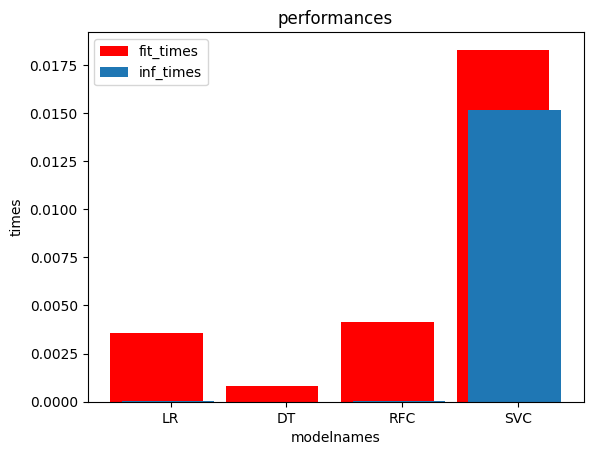

In [36]:
model_names = ["LR","DT","RFC","SVC"]
bar_width = 0.25

# Create an array for the x-axis positions
x = np.arange(len(model_names))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(x, fit_times, color ='r', label ='fit_times') # training accuracy: don't forget to add labels
bar2 = ax.bar(x+0.1, inf_times, label ='inf_times') # testing accuracy

# Add labels, title, and legend
ax.set_xlabel("modelnames")
ax.set_ylabel("times")
ax.set_title("performances")
# set proper x ticks: I'll help you with this one
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?

1. Since the decision tree has the lowest fit_time as seen in the plot, it is the fastest.
2. The decision tree also has the lowest time to infer, although this is very hard to see in the plot it can be seen in the infer_time vector.
3. The random forest and the support vector machine have the highest train accuracies. The model with the highest test accuracy is the random forest. The random forest has a train score of 100% and a test_score of roughly 40%.
4. Definitely the Random forest. It has the highest test score and the time it took to train the model was average. A small note is that I probably did not use the best SVM since I had to reduce the parameters in order to let it run under 15 minutes. The SVM also has a very large fit time which is unpleasant to work with. I would also not use the decision tree since it has the lowest test accuracy and the logistic performs close to the random forest but overall is a little bit worse in all aspects.